## EXERCISE 1 : Generate 1-D Gaussian Distribution from Uniform Noise
In this exercise, we are going to generate 1-D Gaussian distribution from a n-D uniform distribution. This is a toy exercise in order to understand the ability of GANs (generators) to generate arbitrary distributions from random noise.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, SimpleRNN, Input
from keras.layers import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
import numpy as np
import matplotlib.pyplot as plt
import scipy

np.random.seed(1)

Generate training data - Gaussian Distribution

In [10]:
def generate_data(n_samples = 10000,n_dim=1):
  return np.random.randn(n_samples, n_dim)

Let us define a function that gives you a keras model of general feedforward network based on the parameters.

In [11]:
# Cell 5: set_model
def set_model(input_dim, output_dim, hidden_dim=64, n_layers=1, activation='tanh',
              optimizer='adam', loss='binary_crossentropy'):
    
    model = Sequential()
    
    # لایه ورودی و اولین لایه مخفی
    model.add(Dense(hidden_dim, input_dim=input_dim, activation=activation))
    
    # لایه‌های مخفی اضافی (در صورت نیاز)
    for _ in range(n_layers - 1):
        model.add(Dense(hidden_dim, activation=activation))
        
    # لایه خروجی
    # اگر تابع هزینه باینری باشد (برای Discriminator)، اکتیویشن خروجی باید Sigmoid باشد
    # اگر تابع هزینه MSE باشد (برای Generator)، اکتیویشن معمولا Linear یا Tanh است
    if loss == 'binary_crossentropy':
        final_activation = 'sigmoid'
    else:
        final_activation = 'linear' # یا 'tanh' بسته به محدوده داده‌ها
        
    model.add(Dense(output_dim, activation=final_activation))
    
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [12]:
# Cell 6: get_gan_network
def get_gan_network(discriminator, random_dim, generator, optimizer='adam'):
    # ابتدا Discriminator را غیرقابل آموزش می‌کنیم (فقط در قالب مدل GAN)
    discriminator.trainable = False
    
    # ورودی نویز برای Generator
    gan_input = Input(shape=(random_dim,))
    
    # خروجی Generator
    x = generator(gan_input)
    
    # خروجی Discriminator که ورودی‌اش را از Generator می‌گیرد
    gan_output = discriminator(x)
    
    # مدل نهایی GAN: ورودی نویز -> خروجی احتمال واقعی بودن
    gan = Model(inputs=gan_input, outputs=gan_output)
    
    # کامپایل مدل GAN
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

Let us now write the training function for a GAN

In [13]:
NOISE_DIM = 10
DATA_DIM = 1
G_LAYERS = 1
D_LAYERS = 1

In [14]:
# Cell 8: train_gan
def train_gan(epochs=1, batch_size=128):
    # تولید داده‌های آموزشی واقعی (توزیع نرمال)
    x_train = generate_data(n_samples=12800, n_dim=DATA_DIM)
    
    # ساخت مدل‌ها
    generator = set_model(NOISE_DIM, DATA_DIM, n_layers=G_LAYERS, activation='tanh', loss='mean_squared_error')
    discriminator = set_model(DATA_DIM, 1, n_layers=D_LAYERS, activation='tanh', loss='binary_crossentropy')
    gan = get_gan_network(discriminator, NOISE_DIM, generator, 'adam')

    for e in range(1, epochs + 1):
        # 1. آموزش Discriminator
        
        # تولید نویز
        noise = np.random.rand(batch_size, NOISE_DIM)
        # تولید داده‌های جعلی توسط Generator
        generated_values = generator.predict(noise)
        
        # انتخاب داده‌های واقعی
        true_batch = x_train[np.random.choice(x_train.shape[0], batch_size, replace=False), :]
        
        # ترکیب داده‌های جعلی و واقعی
        X = np.concatenate([generated_values, true_batch])
        
        # ساخت برچسب‌ها (Labels)
        # 0 برای جعلی‌ها، 0.9 برای واقعی‌ها (Label Smoothing)
        y_dis = np.zeros(2 * batch_size)
        y_dis[batch_size:] = 0.9 
        
        # فعال کردن آموزش Discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(X, y_dis)
        
        # 2. آموزش Generator
        
        # تولید نویز جدید
        noise = np.random.rand(batch_size, NOISE_DIM)
        # برچسب‌ها برای Generator همه 1 هستند (چون می‌خواهد Discriminator را فریب دهد)
        y_gen = np.ones(batch_size)
        
        # غیرفعال کردن آموزش Discriminator هنگام آموزش GAN
        discriminator.trainable = False
        gan.train_on_batch(noise, y_gen)

    return generator, discriminator

In [15]:
# Cell: generate_data
def generate_data(n_samples, n_dim=1, mu=0.0, sigma=1.0):
    """
    تولید داده‌های مصنوعی بر اساس توزیع نرمال (گاوسی) با میانگین و انحراف معیار مشخص.

    پارامترها:
    - n_samples: تعداد نمونه‌هایی که باید تولید شوند.
    - n_dim: بُعد داده‌ها (برای تمرین ۱ بُعد ۱ است).
    - mu: میانگین (Mean) توزیع.
    - sigma: انحراف معیار (Standard Deviation) توزیع.
    
    خروجی:
    - یک آرایه NumPy با ابعاد (n_samples, n_dim) حاوی داده‌های گاوسی.
    """
    # استفاده از numpy.random.normal برای تولید داده‌های گاوسی
    data = np.random.normal(loc=mu, scale=sigma, size=(n_samples, n_dim))
    return data

In [16]:
generator, discriminator = train_gan()

d:\Uni\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


Let us visualize what the generator has learned.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
1st order moment -  True :  0.0 , GAN : [0.]
2nd order moment -  True :  0.993800675880421 , GAN : [0.03228501]
3rd order moment -  True :  0.04224919831436267 , GAN : [0.00017567]
4th order moment -  True :  2.9013848672859766 , GAN : [0.00285027]


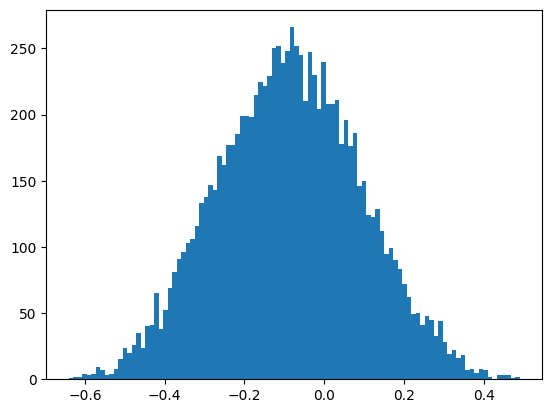

In [17]:
noise = np.random.rand(10000,NOISE_DIM)
generated_values = generator.predict(noise)
plt.hist(generated_values,bins=100)


true_gaussian = [np.random.randn() for x in range(10000)]

print('1st order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 1) , ', GAN :', scipy.stats.moment(generated_values,1))
print('2nd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 2) , ', GAN :', scipy.stats.moment(generated_values,2))
print('3rd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 3) , ', GAN :', scipy.stats.moment(generated_values,3))
print('4th order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 4) , ', GAN :', scipy.stats.moment(generated_values,4))
plt.show()

## EXERCISE 2 : Train real GAN - MINST Digit Generation 
Here we try to generate 'fake' digits between 0 and 9 as if they belong to the MINST dataset using a simple Generative Adversarial Network (GAN)

#### Generative Adversarial Networks (GANs)

GANs is a method for training generative models that was proposed in 2014 by Goodfellow et al. There are two neural networks in a GAN. One is called the generator which takes a random noise as input and outputs an image. The other is called the discriminator which is a binary classifier to classify whether an input image is a real image or a fake image generated by the generator. The goal of the generator is to generate images that can fool the discriminator into thinking the images are real.

This iterative process of generator trying to fool the discriminator and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are random noise vectors,  $G(z)$ are the fake images generated by the generator $G$, $D$ is a probability of the input of the discriminator being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

In practice, for the objective of the generator, instead of minimizing the following objection:
$$\underset{G}{\text{minimize}}\; \left[\log \left(1-D(G(z))\right)\right]$$
We use a different objective for the generator: maximizing the probability of the disciminator being fooled.

$$\underset{G}{\text{maximize}}\; \left[\log \left(D(G(z))\right)\right]$$

This helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661).

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$



#### Libraries
run this cell before doing anything!

In [23]:
import math
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## Load Data and Explore

In [24]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root='./data',
                          train=True,
                          download=True,
                          transform=transform)

100.0%
100.0%
100.0%
100.0%


In [25]:
print(train_ds.data.shape)
print(train_ds.targets.shape)
print(train_ds.classes)
print(train_ds.data[0])
print(train_ds.targets[0])
print(train_ds.data[0].max())
print(train_ds.data[0].min())
print(train_ds.data[0].float().mean())
print(train_ds.data[0].float().std())

torch.Size([60000, 28, 28])
torch.Size([60000])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   

In [26]:
# Build dataloader
dl = DataLoader(dataset=train_ds,
                shuffle=True,
                batch_size=64)

In [27]:
# Examine a sample batch from the dataloader
image_batch = next(iter(dl))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)

2 <class 'list'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


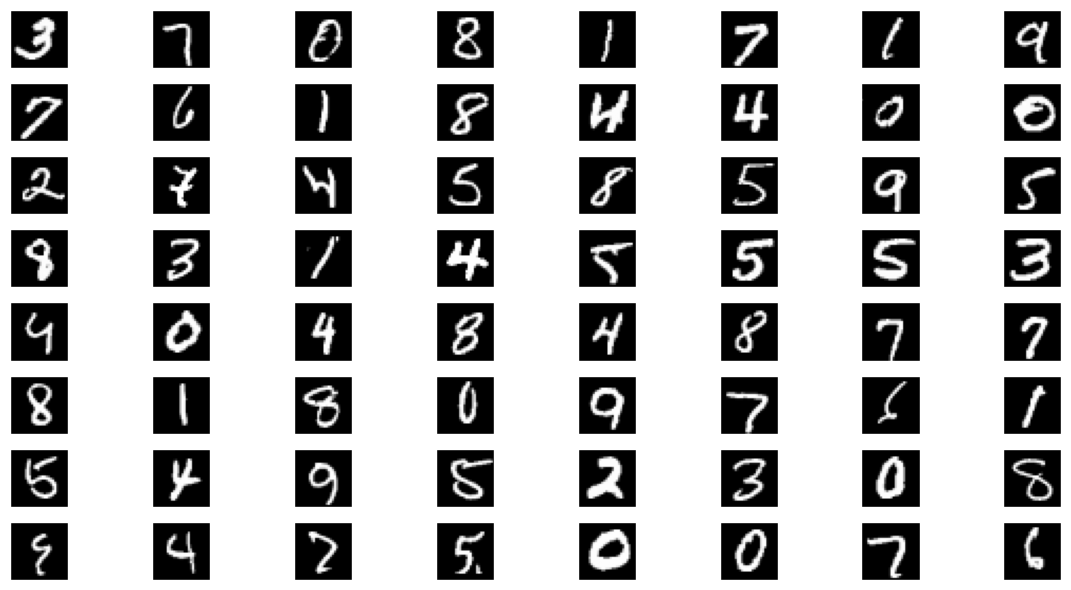

In [28]:
## ----------------------------------------------------------------------------
## Visualise a sample batch
## ----------------------------------------------------------------------------

def display_images(images, n_cols=4, figsize=(12, 6)):
    """
    Utility function to display a collection of images in a grid

    Parameters
    ----------
    images: Tensor
            tensor of shape (batch_size, channel, height, width)
            containing images to be displayed
    n_cols: int
            number of columns in the grid

    Returns
    -------
    None
    """
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        # make dims H x W x C
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

display_images(images=image_batch[0], n_cols=8)

## Define the Network

### Discriminator Network

In [29]:
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features, 128)
        self.leaky_relu1 = nn.LeakyReLU(0.2)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(128, 64)
        self.leaky_relu2 = nn.LeakyReLU(0.2)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(64, 32)
        self.leaky_relu3 = nn.LeakyReLU(0.2)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc4 = nn.Linear(32, out_features)
        # Note: No Sigmoid here because we use BCEWithLogitsLoss later

    def forward(self, x):
        # Flatten the image: (Batch_Size, 1, 28, 28) -> (Batch_Size, 784)
        x = x.view(x.size(0), -1)
        
        x = self.dropout1(self.leaky_relu1(self.fc1(x)))
        x = self.dropout2(self.leaky_relu2(self.fc2(x)))
        x = self.dropout3(self.leaky_relu3(self.fc3(x)))
        
        # Logits output
        x = self.fc4(x)
        return x

### Generator Network

In [30]:
class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        
        # Latent vector -> 32
        self.fc1 = nn.Linear(in_features, 32)
        self.relu1 = nn.LeakyReLU(0.2)
        self.dropout1 = nn.Dropout(0.3)
        
        # 32 -> 64
        self.fc2 = nn.Linear(32, 64)
        self.relu2 = nn.LeakyReLU(0.2)
        self.dropout2 = nn.Dropout(0.3)
        
        # 64 -> 128
        self.fc3 = nn.Linear(64, 128)
        self.relu3 = nn.LeakyReLU(0.2)
        self.dropout3 = nn.Dropout(0.3)
        
        # 128 -> 784 (Image Size)
        self.fc4 = nn.Linear(128, out_features)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.dropout3(self.relu3(self.fc3(x)))
        
        # Output range (-1, 1) via Tanh
        x = self.tanh(self.fc4(x))
        return x

## Define Losses
Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:


`real_labels = torch.ones(real_images.size(0), 1, device=device)`

`fake_labels = torch.zeros(fake_images.size(0), 1, device=device)`

to obtain the loss required gor the generator and discripminator model, you will feed the real images and the fake images to variables 'G' and 'D' respectively 
and calculate loss base on the output of these two modules. note that 'G' is an object of the generator class and 'D' is an object of the discriminator class which you will declare later on in the implementation!

In [31]:
def real_loss(predicted_outputs, loss_fn, device):
    batch_size = predicted_outputs.size(0)
    # اهداف واقعی باید 1 باشند
    targets = torch.ones(batch_size, device=device)
    loss = loss_fn(predicted_outputs.squeeze(), targets)
    return loss

def fake_loss(predicted_outputs, loss_fn, device):
    batch_size = predicted_outputs.size(0)
    # اهداف جعلی باید 0 باشند
    targets = torch.zeros(batch_size, device=device)
    loss = loss_fn(predicted_outputs.squeeze(), targets)
    return loss

## Train the network
Discriminator and Generator will be trained together we need separate optimizer for them

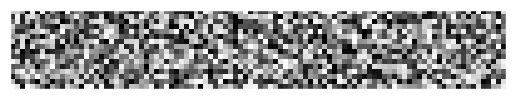

In [32]:
#Sample generation of latent vector
z_size = 100
z = np.random.uniform(-1, 1, size=(16, z_size))
plt.imshow(z, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [33]:
def train_minst_gan(d, g, d_optim, g_optim, loss_fn, dl, n_epochs, device, verbose=False):
    print(f'Training on [{device}]...')
    
    # انتقال مدل‌ها به GPU/CPU
    d.to(device)
    g.to(device)
    
    d_losses = []
    g_losses = []
    
    # بردار ثابت برای مشاهده پیشرفت تولید تصاویر در طول زمان
    fixed_z = torch.randn(16, 100, device=device) 
    fixed_samples = []

    for epoch in range(n_epochs):
        d_epoch_loss = 0.0
        g_epoch_loss = 0.0
        
        d.train()
        g.train()
        
        for i, (real_images, _) in enumerate(dl):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            # --- تغییر مقیاس تصاویر ---
            # تصاویر MNIST در بازه [0, 1] هستند، باید به [-1, 1] تبدیل شوند (چون خروجی Generator تانژانت هیپربولیک است)
            real_images = real_images * 2 - 1 
            
            # ============================================
            #  TRAIN DISCRIMINATOR
            # ============================================
            d_optim.zero_grad()
            
            # 1. آموزش با تصاویر واقعی
            d_real_logits = d(real_images)
            d_loss_real = real_loss(d_real_logits, loss_fn, device)
            
            # 2. آموزش با تصاویر جعلی
            z = torch.randn(batch_size, 100, device=device) # تولید نویز
            fake_images = g(z)
            
            # استفاده از detach() تا گرادیان‌ها به سمت Generator نروند
            d_fake_logits = d(fake_images.detach())
            d_loss_fake = fake_loss(d_fake_logits, loss_fn, device)
            
            # جمع هزینه‌ها و آپدیت
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optim.step()
            
            d_epoch_loss += d_loss.item()

            # ============================================
            #  TRAIN GENERATOR
            # ============================================
            g_optim.zero_grad()
            
            # تولید مجدد نویز (یا استفاده از همان قبلی)
            z = torch.randn(batch_size, 100, device=device)
            fake_images = g(z)
            
            # Generator می‌خواهد تصاویرش "واقعی" تشخیص داده شوند (Target = 1)
            g_logits = d(fake_images)
            g_loss = real_loss(g_logits, loss_fn, device)
            
            g_loss.backward()
            g_optim.step()
            
            g_epoch_loss += g_loss.item()
            
        # محاسبه میانگین خطاها در هر ایپاک
        avg_d_loss = d_epoch_loss / len(dl)
        avg_g_loss = g_epoch_loss / len(dl)
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        
        print(f"Epoch [{epoch+1}/{n_epochs}] | D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")
        
        # ذخیره نمونه‌ها برای مصورسازی
        with torch.no_grad():
            g.eval()
            samples = g(fixed_z).detach().cpu()
            fixed_samples.append(samples)
    
    # ذخیره نمونه‌های تولید شده در فایل
    with open('fixed_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)
        
    return d_losses, g_losses

In [34]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
d = Discriminator(in_features=784, out_features=1)
g = Generator(in_features=100, out_features=784)
#g = Generator(100, 32, 784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.002)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 100
d_losses, g_losses = train_minst_gan(d, g, d_optim, g_optim,
                                     loss_fn, dl, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_

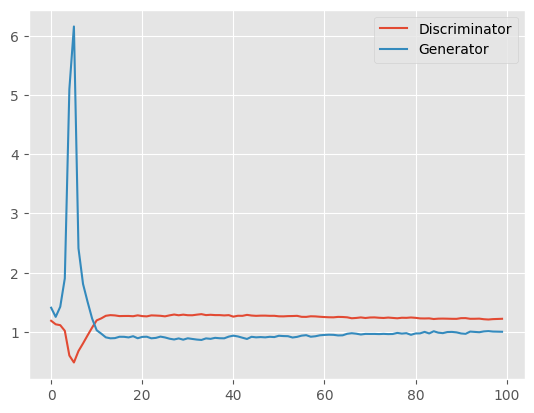

In [35]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

In [36]:
##
## Visualize image generation improvements
##

def show_generated_images(epoch, n_cols=8):
    # load saved images
    with open('fixed_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)
    epoch_data = saved_data[epoch-1]
    # re-scale back to 0-1
    epoch_data = (epoch_data + 1) / 2
    # re-shape to (batch_size, channel, height, width)
    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    display_images(images=image_batch, n_cols=n_cols, figsize=(12, 4))

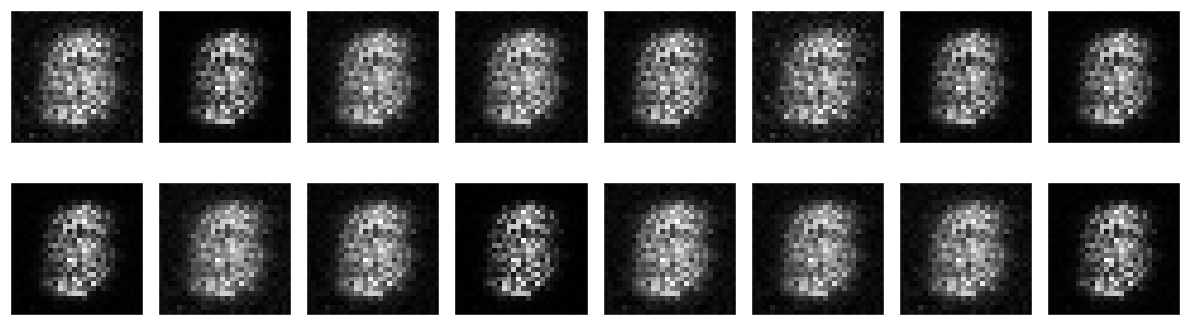

In [37]:
show_generated_images(epoch=1, n_cols=8)

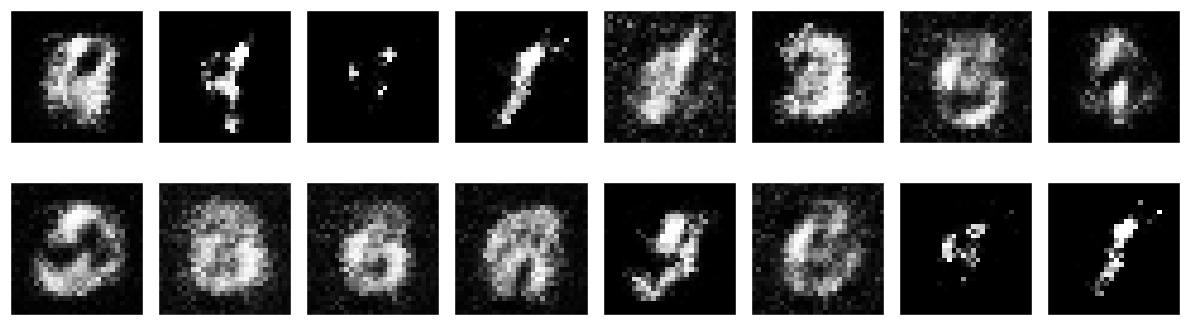

In [38]:
show_generated_images(epoch=10, n_cols=8)

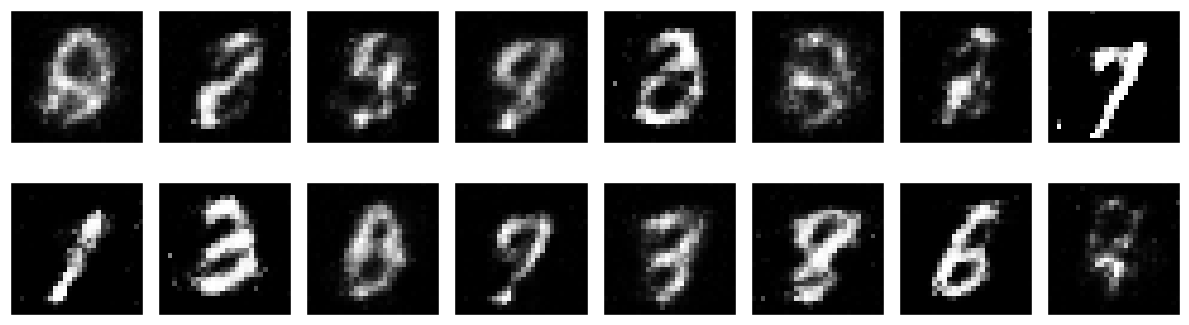

In [39]:
show_generated_images(epoch=50, n_cols=8)

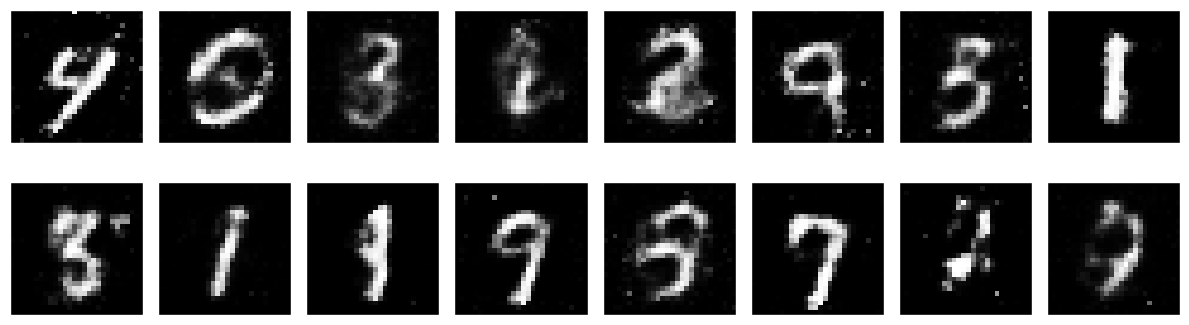

In [40]:
show_generated_images(epoch=100, n_cols=8)

## Test the network
The trained generator can be used to generate a fake random digit that'd look like as if it came from MNIST dataset.
Discriminator can be discarded now.

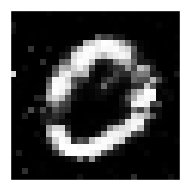

In [41]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))